# Stock Price Prediction for Google stocks

In [18]:
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [2]:
#using the pandas web datareader to bring in the stocks data of past 5 years
#pulling in Google's past 5 years of stock data from Yahoo finance

start = datetime.datetime(2015,1,2)
end = datetime.datetime(2020,1,16)

df = web.DataReader("GOOGL", "yahoo", start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,535.799988,527.880005,532.599976,529.549988,1324000,529.549988
2015-01-05,527.989990,517.750000,527.150024,519.460022,2059100,519.460022
2015-01-06,521.210022,505.549988,520.500000,506.640015,2722800,506.640015
2015-01-07,511.489990,503.649994,510.950012,505.149994,2345900,505.149994
2015-01-08,507.500000,495.019989,501.510010,506.910004,3652700,506.910004


In [3]:
#storing the required feature in a seperate series
close_px = df['Adj Close']

#calcualting moving average for this series with moving window of 100 days
mavg = close_px.rolling(window = 100).mean()
mavg.tail()

Date
2020-01-10    1273.895598
2020-01-13    1276.460598
2020-01-14    1278.850698
2020-01-15    1281.327498
2020-01-16    1284.293298
Name: Adj Close, dtype: float64

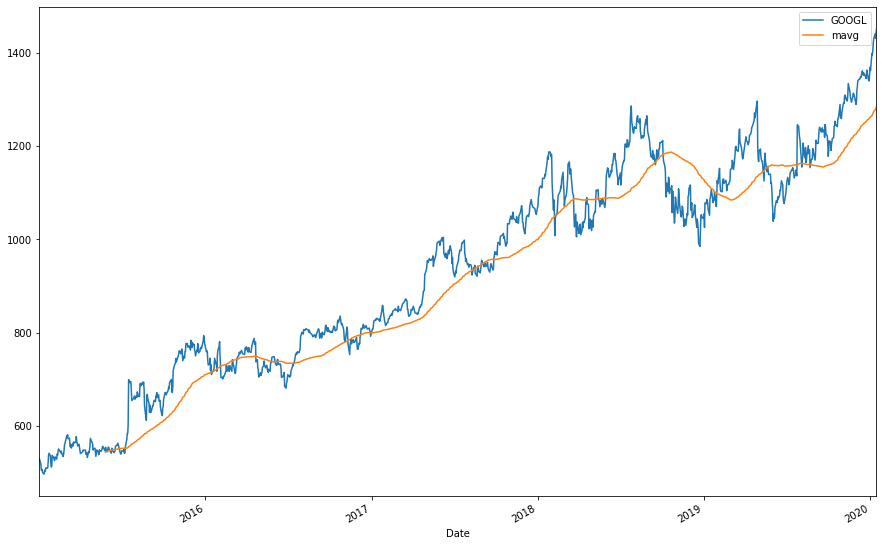

In [4]:
%matplotlib inline
plt.figure(figsize = (15,10))
from matplotlib import style
close_px.plot(label = "GOOGL")
mavg.plot(label = "mavg")
plt.legend()

**Calculating the Returns**

Return = (initial price / final price ) - 1

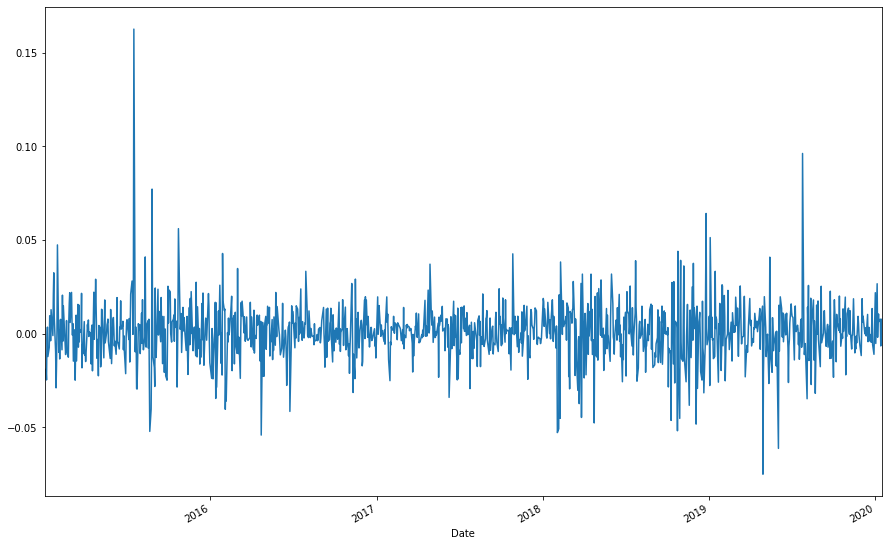

In [7]:
rets = close_px/close_px.shift(1)-1
plt.figure(figsize = (15,10))
rets.plot(label = "return")

# Prediction of stock prices

Building the model

In [14]:
#selecting the esssentinal features from the main dataframe
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,535.799988,527.880005,532.599976,529.549988,1324000,529.549988
2015-01-05,527.989990,517.750000,527.150024,519.460022,2059100,519.460022
2015-01-06,521.210022,505.549988,520.500000,506.640015,2722800,506.640015
2015-01-07,511.489990,503.649994,510.950012,505.149994,2345900,505.149994
2015-01-08,507.500000,495.019989,501.510010,506.910004,3652700,506.910004


## Performing Feature Engineering 

In [15]:
# creating a new dataframe- dfreg
dfreg = df.loc[:,['Adj Close', 'Volume']]

#creating two new features: HL_PCL and PCT_change
dfreg['HL_PCL'] = (df['High']-df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

#displaying this new feature engineered dataframe
dfreg.head()

,Adj Close,Volume,HL_PCL,PCT_change
Date,,,,
2015-01-02,529.549988,1324000,1.495606,-0.572660
2015-01-05,519.460022,2059100,1.971276,-1.458788
2015-01-06,506.640015,2722800,3.090959,-2.662821
2015-01-07,505.149994,2345900,1.552014,-1.135144
2015-01-08,506.910004,3652700,2.461978,1.076747


In [30]:
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_validate

In [31]:
#dropping missing values
dfreg.fillna(value = -99999, inplace = True)

print(dfreg.shape)
#sepearating 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

#separating the label here; we wish to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'],1))

#scaling the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

#Finally we want to find data series of late X and early X(train) for the model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#seperate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X', X.shape)
print('Dimension of y', y.shape)

(1269, 5)
Dimension of X (1256, 4)
Dimension of y (1256,)


In [32]:
# Separation of training and testing of model by cross validation train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#linear regression
LR_regressor = LinearRegression(n_jobs = -1)
LR_regressor.fit(X_train, y_train)

#quadratic regression 2
regressor_2 = make_pipeline(PolynomialFeatures(2), Ridge())
regressor_2.fit(X_train, y_train)

#quadratic regression 3 
regressor_3 = make_pipeline(PolynomialFeatures(3), Ridge())
regressor_3.fit(X_train, y_train)

#KNN regression
KNN_regressor = KNeighborsRegressor(n_neighbors = 2)
KNN_regressor.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [34]:
#calculating the confidence scores for each model
confidence_1 = LR_regressor.score(X_test, y_test)
confidence_2 = regressor_2.score(X_test, y_test)
confidence_3 = regressor_3.score(X_test, y_test)
confidence_4 = KNN_regressor.score(X_test, y_test)

print("CONFIDENCE SCORE",end = '\n')
print("Linear regression: ",confidence_1)
print("Quadratic regression 2: ",confidence_2)
print("Quadratic regression 3: ",confidence_3)
print("KNN regression: ",confidence_4)

CONFIDENCE SCORE
Linear regression:  0.9669087392814709
Quadratic regression 2:  0.9648791619514346
Quadratic regression 3:  0.9651430271001762
KNN regression:  0.9403402465426035


**The above are the confidence scores for various model, based on their predictions made for the testing set. Results clearly shows that the linear regression model does much better**

## Plotting down the Predictions

In [35]:
# Printing the forecast
forecast_set = LR_regressor.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidence_1, forecast_out)

[1350.1131669  1342.9403776  1368.14026852 1365.26328143 1388.94223095
 1393.90179017 1401.73700336 1419.37629201 1430.17024729 1438.23027965
 1433.49892806 1439.35036229 1448.83759938] 0.9669087392814709 13


In [36]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

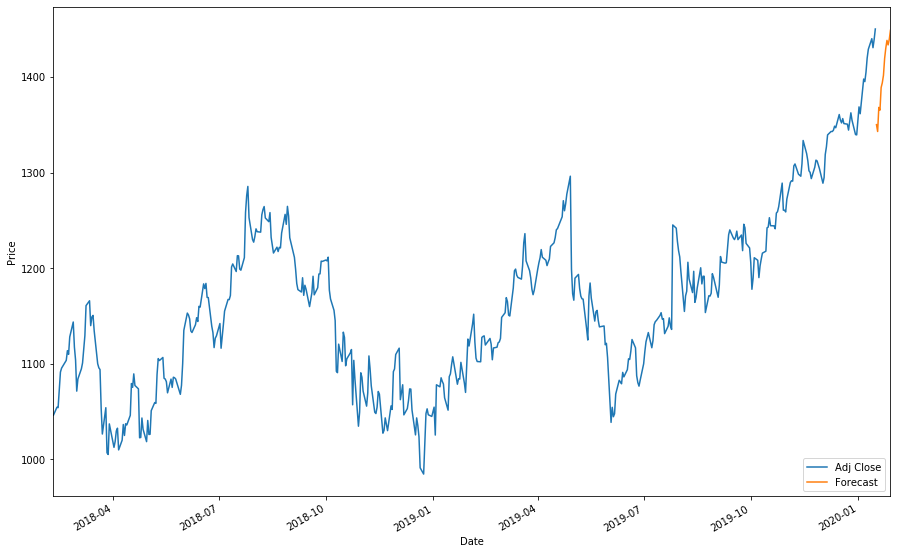

In [37]:
plt.figure(figsize = (15,10))
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

**The above plot states the predictions given by the model**